Dataframe Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_supply = pd.read_csv('csv/Supply Data.csv')
df_demand = pd.read_csv('csv/Demand Data.csv')

In [3]:
df_supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     840 non-null    object 
 1   Active drivers           840 non-null    int64  
 2   Online (h)               840 non-null    int64  
 3   Has booking (h)          840 non-null    int64  
 4   Waiting for booking (h)  840 non-null    int64  
 5   Hours per active driver  840 non-null    float64
 6   Rides per online hour    840 non-null    float64
 7   Finished Rides           795 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 52.6+ KB


In [4]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Date                         839 non-null    object
 1   People saw 0 cars (unique)   839 non-null    int64 
 2   People saw +1 cars (unique)  839 non-null    int64 
 3   Coverage Ratio (%)           839 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 26.3+ KB


In [5]:
df_supply.rename(columns={'Date':'Date_Hour'},inplace=True)
df_demand.rename(columns={'Date':'Date_Hour'},inplace=True)

In [6]:
df_supply_demand = pd.merge(df_supply, df_demand, on='Date_Hour', how='left')

In [7]:
df_supply_demand[['Date','Hour']] = df_supply_demand['Date_Hour'].str.split(" ",expand=True)

In [8]:
df_supply_demand['Date'] = pd.to_datetime(df_supply_demand['Date'])
df_supply_demand['Hour'] = df_supply_demand['Hour'].astype(int)

In [9]:
df_supply_demand['Weekday'] = df_supply_demand['Date'].dt.weekday
df_supply_demand['Weekday Name'] = df_supply_demand['Date'].dt.day_name()

In [10]:
df_supply_demand['Month'] = df_supply_demand['Date'].dt.month
df_supply_demand['Month Name'] = df_supply_demand['Date'].dt.month_name()

In [11]:
df_supply_demand['Total People'] = df_supply_demand['People saw 0 cars (unique)'] + df_supply_demand['People saw +1 cars (unique)'] 

In [12]:
df_supply_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date_Hour                    840 non-null    object        
 1   Active drivers               840 non-null    int64         
 2   Online (h)                   840 non-null    int64         
 3   Has booking (h)              840 non-null    int64         
 4   Waiting for booking (h)      840 non-null    int64         
 5   Hours per active driver      840 non-null    float64       
 6   Rides per online hour        840 non-null    float64       
 7   Finished Rides               795 non-null    float64       
 8   People saw 0 cars (unique)   839 non-null    float64       
 9   People saw +1 cars (unique)  839 non-null    float64       
 10  Coverage Ratio (%)           839 non-null    float64       
 11  Date                         840 non-null    

<p></p>
<h2>Step 1</h2>

a. 24-hour curve of average demand and supply volume 

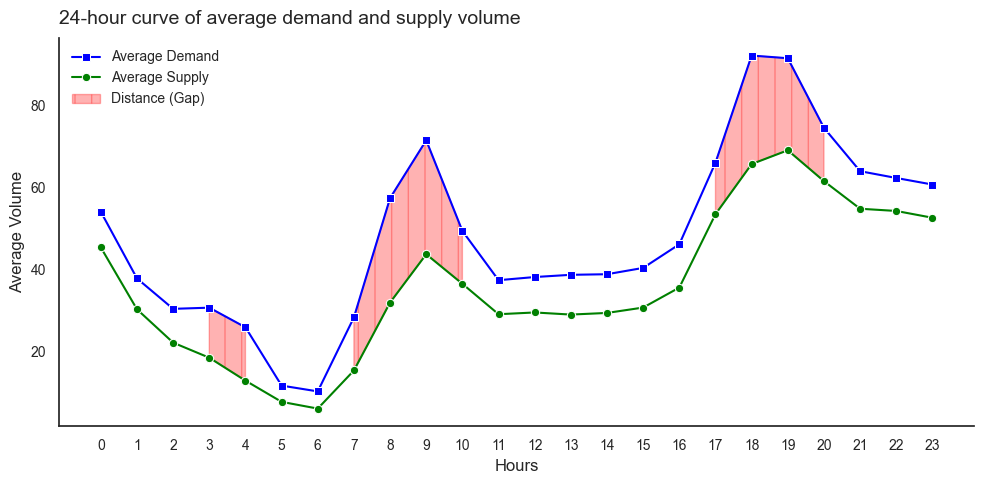

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular médias de demanda e oferta
avg_demand_supply = df_supply_demand.groupby('Hour').agg({
    'People saw +1 cars (unique)': 'mean',
    'Total People': 'mean'
}).reset_index()

# Calcular a diferença (distância) entre demanda e oferta
avg_demand_supply['Gap'] = avg_demand_supply['Total People'] - avg_demand_supply['People saw +1 cars (unique)']


# Calcular a distância entre y1 e y2
distance = np.abs(avg_demand_supply['Gap'])

# Definir um limite (por exemplo, distância maior que 0.5)
threshold = avg_demand_supply['Gap'].quantile(0.60)


# Configurar um tema minimalista
sns.set_theme(style="white", context="notebook")

# Criar o gráfico
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=avg_demand_supply, x='Hour', y='Total People', 
    label='Average Demand', marker='s', color="blue"
)
sns.lineplot(
    data=avg_demand_supply, x='Hour', y='People saw +1 cars (unique)', 
    label='Average Supply', marker='o', color="green"
)
plt.fill_between(
    avg_demand_supply['Hour'], 
    avg_demand_supply['Total People'], 
    avg_demand_supply['People saw +1 cars (unique)'], 
    where=(distance > threshold),
    color="red", alpha=0.3, label="Distance (Gap)", hatch="|"
)

# Configurar detalhes do gráfico
plt.title('24-hour curve of average demand and supply volume', fontsize=14, loc="left", pad=10)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Average Volume', fontsize=12)
plt.xticks(range(0, 24, 1), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, frameon=False)
sns.despine()  # Remove bordas do gráfico para um estilo mais limpo
plt.tight_layout()

# Mostrar o gráfico
plt.show()


b. Undersupplied hours during a weekly period (Monday to Sunday) 

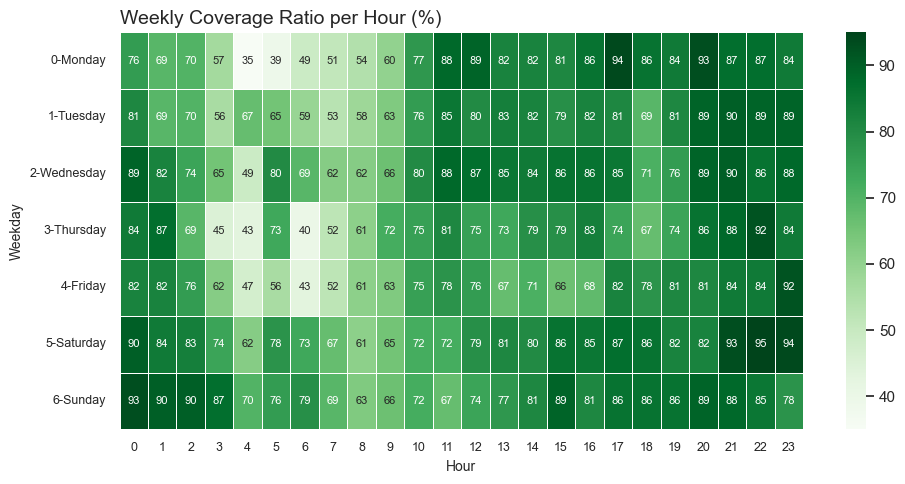

In [16]:
# Calcular a média de 'Coverage Ratio (%)' por dia da semana e hora
coverage_by_weekday_hour = df_supply_demand.groupby(['Weekday', 'Weekday Name', 'Hour'])['Coverage Ratio (%)'].mean().round(0).unstack()

# Criar o heatmap minimalista
plt.figure(figsize=(10, 5))
sns.heatmap(
    coverage_by_weekday_hour, 
    cmap="Greens", 
    annot=True, 
    fmt=".0f", 
    cbar=True,  # Remove barra de cores para um visual mais limpo
    annot_kws={"size": 8},
    linewidths=0.5  # Linhas finas para separar células
)

# Configurações minimalistas
plt.title('Weekly Coverage Ratio per Hour (%)', fontsize=14, loc='left')
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Weekday', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9, rotation=0)  # Deixar rótulos dos dias alinhados horizontalmente
sns.despine(left=True, bottom=True)  # Remove bordas ao redor do gráfico

# Mostrar o gráfico
plt.tight_layout()
plt.show()


<p></p>
<h2>Step 2:</h2>

In [17]:
df_supply_demand_calc = df_supply_demand.copy()

In [18]:
coverage_threshold = 100

df_supply_demand_calc['Coverage per Online'] = df_supply_demand_calc['Coverage Ratio (%)'] / df_supply_demand_calc['Online (h)']
df_supply_demand_calc['Coverage Deficit'] = coverage_threshold - df_supply_demand_calc['Coverage Ratio (%)']
df_supply_demand_calc['Additional Hours Needed'] = df_supply_demand_calc['Coverage Deficit'] / df_supply_demand_calc['Coverage per Online']
df_supply_demand_calc['New Coverage Ratio'] = df_supply_demand_calc['Coverage per Online'] * (df_supply_demand_calc['Online (h)'] + df_supply_demand_calc['Additional Hours Needed'])

In [19]:
df_supply_demand_calc.fillna(0, inplace=True)  # Substituir NaN por 0
df_supply_demand_calc.replace([float('inf'), float('-inf')], 0, inplace=True)  # Substituir infinitos por 0

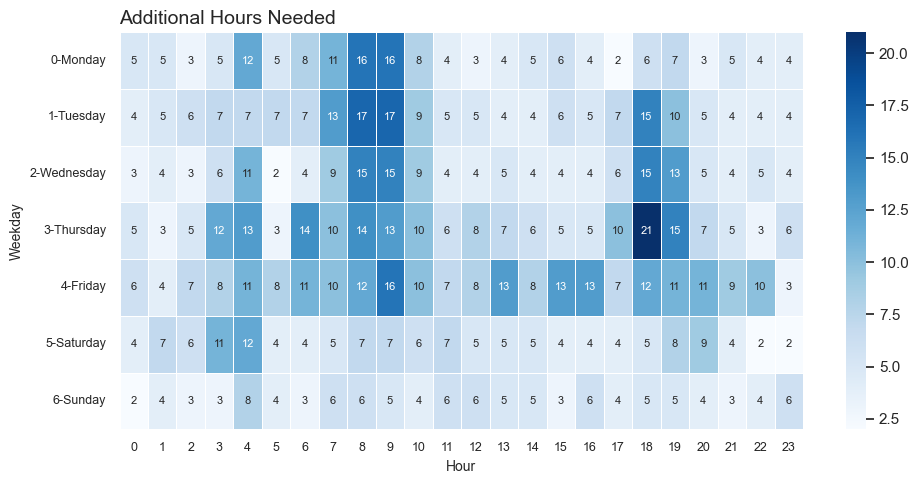

In [20]:
avg_additional_hours_by_weekday_hour = df_supply_demand_calc.groupby(['Weekday', 'Weekday Name', 'Hour'])['Additional Hours Needed'].mean().round(0).unstack()

# Criar o heatmap minimalista
plt.figure(figsize=(10, 5))
sns.heatmap(
    avg_additional_hours_by_weekday_hour, 
    cmap="Blues", 
    annot=True, 
    fmt=".0f", 
    cbar=True,  # Remove barra de cores para um visual mais limpo
    annot_kws={"size": 8},
    linewidths=0.5  # Linhas finas para separar células
)

# Configurações minimalistas
plt.title('Additional Hours Needed', fontsize=14, loc='left')
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Weekday', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9, rotation=0)  # Deixar rótulos dos dias alinhados horizontalmente
sns.despine(left=True, bottom=True)  # Remove bordas ao redor do gráfico

# Mostrar o gráfico
plt.tight_layout()
plt.show()

<p></p>
<h2>Step 3:</h2>

In [21]:
df_supply_demand_income_calc = df_supply_demand_calc.copy()

In [22]:
df_supply_demand_income_calc['Hour Rate'] = df_supply_demand_income_calc['Rides per online hour'] * 10 * 0.8

In [49]:
df_supply_demand_income_calc.to_csv('test.csv')

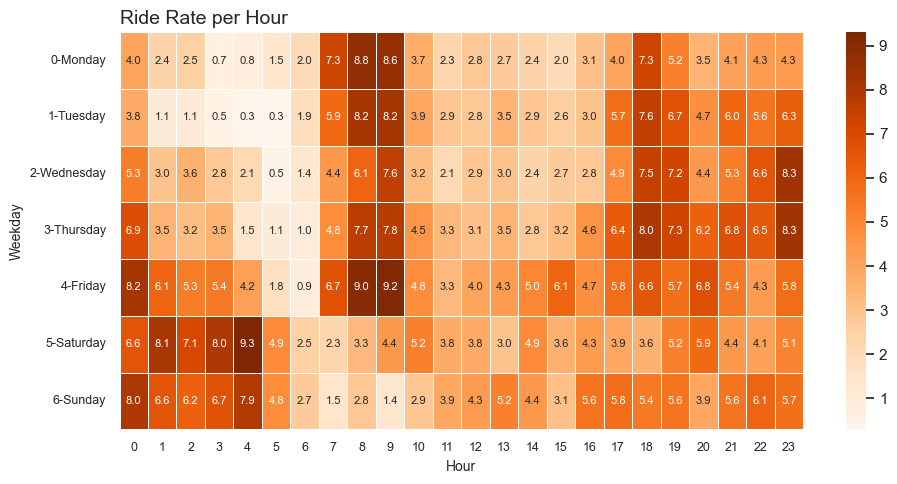

In [23]:
avg_ride_value_by_weekday_hour = df_supply_demand_income_calc.groupby(['Weekday', 'Weekday Name', 'Hour'])['Hour Rate'].mean().round(1).unstack()

# Criar o heatmap minimalista
plt.figure(figsize=(10, 5))
sns.heatmap(
    avg_ride_value_by_weekday_hour, 
    cmap="Oranges", 
    annot=True, 
    fmt=".1f", 
    cbar=True,  # Remove barra de cores para um visual mais limpo
    annot_kws={"size": 8},
    linewidths=0.5  # Linhas finas para separar células
)

# Configurações minimalistas
plt.title('Ride Rate per Hour', fontsize=14, loc='left')
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Weekday', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9, rotation=0)  # Deixar rótulos dos dias alinhados horizontalmente
sns.despine(left=True, bottom=True)  # Remove bordas ao redor do gráfico

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [24]:
# Calcular Additional Rides diretamente do número de pessoas que não viram carros
df_supply_demand_income_calc['Additional Rides'] = df_supply_demand_income_calc['People saw 0 cars (unique)']

# Calcular Total Revenue e Driver Income com base em Additional Rides
df_supply_demand_income_calc['Total Revenue'] = df_supply_demand_income_calc['Additional Rides'] * 10
df_supply_demand_income_calc['Driver Income'] = df_supply_demand_income_calc['Total Revenue'] * 0.8

# Garantir renda baseada nas horas online + horas adicionais
df_supply_demand_income_calc['Guaranteed Income'] = (
    (df_supply_demand_income_calc['Online (h)'] + df_supply_demand_income_calc['Additional Hours Needed']) 
    * df_supply_demand_income_calc['Hour Rate']
)

# Calcular a compensação (caso a renda garantida seja maior que o Driver Income)
df_supply_demand_income_calc['Compensation'] = df_supply_demand_income_calc['Guaranteed Income'] - df_supply_demand_income_calc['Driver Income']

# Ajustar valores negativos (compensação não pode ser negativa)
df_supply_demand_income_calc['Compensation'] = df_supply_demand_income_calc['Compensation'].clip(lower=0)


In [44]:
# Definir horários de pico (exemplo: 7h-9h e 17h-19h)
peak_hours = [3,4, 7, 8, 9, 17, 18, 19, 20]

# Filtrar apenas os horários de pico
df_peak_hours = df_supply_demand_income_calc[df_supply_demand_income_calc['Hour'].isin(peak_hours)]


# Calcular Additional Rides diretamente do número de pessoas que não viram carros
df_peak_hours['Additional Rides'] = df_peak_hours['People saw 0 cars (unique)']

# Calcular Total Revenue e Driver Income com base em Additional Rides
df_peak_hours['Total Revenue'] = df_peak_hours['Additional Rides'] * 10
df_peak_hours['Driver Income'] = df_peak_hours['Total Revenue'] * 0.8

# Garantir renda baseada nas horas online + horas adicionais
df_peak_hours['Guaranteed Income'] = (
    (df_peak_hours['Online (h)'] + df_peak_hours['Additional Hours Needed']) 
    * df_peak_hours['Hour Rate']
)

# Calcular a compensação (caso a renda garantida seja maior que o Driver Income)
df_peak_hours['Compensation'] = df_peak_hours['Guaranteed Income'] - df_peak_hours['Driver Income']

# Ajustar valores negativos (compensação não pode ser negativa)
df_peak_hours['Compensation'] = df_peak_hours['Compensation'].clip(lower=0)

C:\Users\PTFagundRa\AppData\Local\Temp\ipykernel_7156\1495497735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak_hours['Additional Rides'] = df_peak_hours['People saw 0 cars (unique)']
C:\Users\PTFagundRa\AppData\Local\Temp\ipykernel_7156\1495497735.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak_hours['Total Revenue'] = df_peak_hours['Additional Rides'] * 10
C:\Users\PTFagundRa\AppData\Local\Temp\ipykernel_7156\1495497735.py:13: SettingWithCopyWarning: 
A value is trying to be set 

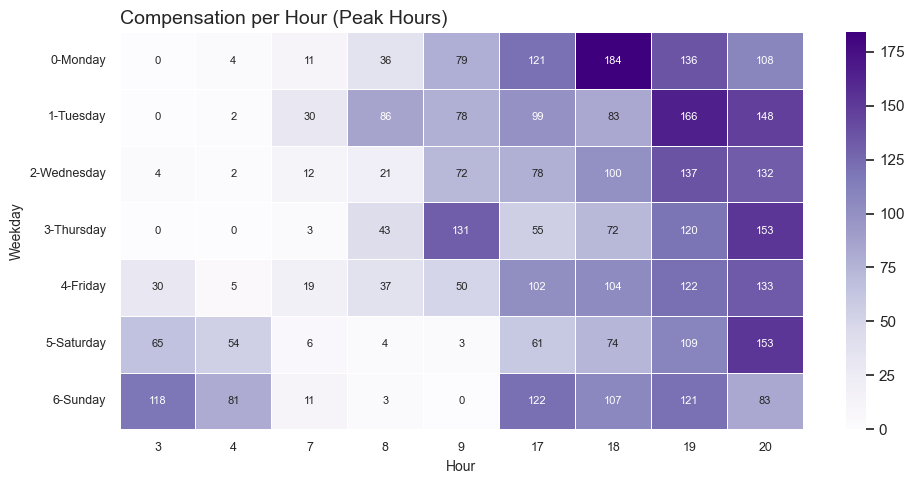

In [45]:

# Calcular a média da compensação por dia da semana e hora
avg_compensation_by_weekday_hour = df_peak_hours.groupby(['Weekday', 'Weekday Name', 'Hour'])['Compensation'].mean().round(0).unstack()

# Criar o heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(
    avg_compensation_by_weekday_hour, 
    cmap="Purples", 
    annot=True, 
    fmt=".0f", 
    cbar=True,
    annot_kws={"size": 8},
    linewidths=0.5
)

# Configurações do gráfico
plt.title('Compensation per Hour (Peak Hours)', fontsize=14, loc='left')
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Weekday', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9, rotation=0)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Mostrar o gráfico
plt.show()
